<a href="https://colab.research.google.com/github/RatchanonMo/curriculum/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:22<00:00, 173MB/s]
100% 2.70G/2.70G [00:22<00:00, 129MB/s]


In [4]:
!unzip new-plant-diseases-dataset.zip -d data

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: data/new pl

In [2]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [5]:
# สำหรับคนที่ยังไม่ได้ลงไลบรารี่ fastbook ให้ uncomment บรรทัด !pip install
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 9.3 MB/s 
     |████████████████████████████████| 197 kB 64.8 MB/s 
     |████████████████████████████████| 1.2 MB 50.0 MB/s 
     |████████████████████████████████| 60 kB 7.7 MB/s 
Mounted at /content/gdrive


In [6]:
from fastbook import *

In [7]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [8]:
get_image_files("data/test/test/")

(#33) [Path('data/test/test/PotatoEarlyBlight3.JPG'),Path('data/test/test/TomatoHealthy2.JPG'),Path('data/test/test/CornCommonRust2.JPG'),Path('data/test/test/PotatoEarlyBlight5.JPG'),Path('data/test/test/TomatoEarlyBlight4.JPG'),Path('data/test/test/AppleScab1.JPG'),Path('data/test/test/PotatoHealthy2.JPG'),Path('data/test/test/TomatoHealthy3.JPG'),Path('data/test/test/AppleCedarRust1.JPG'),Path('data/test/test/PotatoHealthy1.JPG')...]

In [10]:
parent_label("data/test/test/PotatoEarlyBlight3.JPG")

'test'

In [13]:
dls = fields.dataloaders("data/new_plant_diseases/new_plant_diseases/train/")

In [14]:
dls.vocab

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

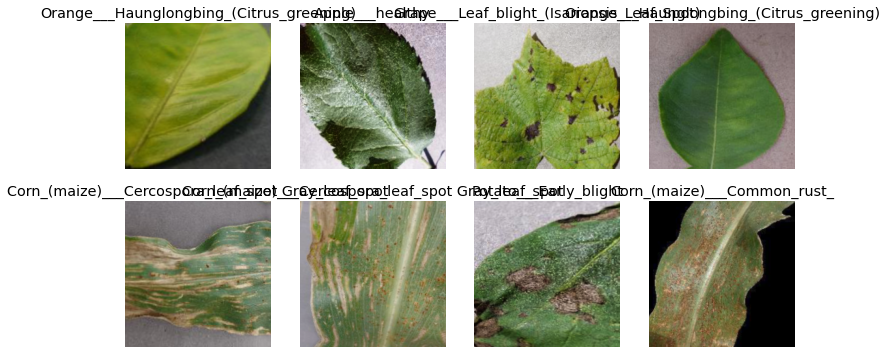

In [16]:
dls.train.show_batch(max_n=8, nrows=2)

In [17]:
learner = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learner.lr_find() # หา learning rate ที่เหมาะสม